In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pointprocesses as ppr

In [3]:
import torch

In [20]:
import os
import sys

In [28]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

Notebook dir /home/manifold/Documents/etudes/map511-p3a


In [30]:
sys.path

['',
 '/home/manifold/Documents/etudes/map511-p3a/notebooks',
 '/home/manifold/miniconda3/envs/pytorch/lib/python37.zip',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.3.1-py3.7-linux-x86_64.egg',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions',
 '/home/manifold/.ipython',
 '/home/manifold/Documents/etudes/map511-p3a']

# Synthetic data

In [31]:
def intensity_function_(t, lam0, alpha, beta, history):
    return lam0 + np.sum(alpha*beta*np.exp(-beta*(t - history))*(t >= history), axis=0)

intensity_function = np.vectorize(intensity_function_, excluded={4})

In [32]:
import itertools
mu = 1.0
tmax = 10.0
alpha = 0.4
beta  = 1.5

print("Expected avg evt no. %.3f" % (tmax*mu/(1.-alpha)))

Expected avg evt no. 16.667


In [33]:
n_traj = 400
sample_trajectories = [ppr.hawkes_exp(tmax, beta, mu, itertools.repeat(alpha)) for _ in range(n_traj)]

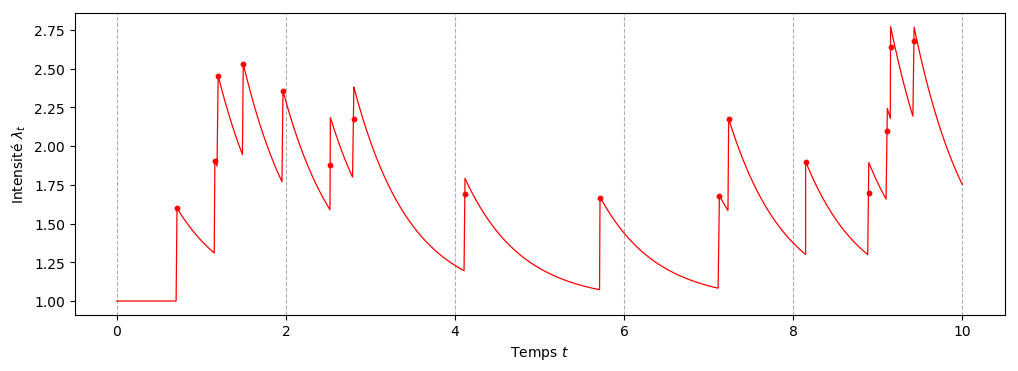

In [34]:
one_traj = sample_trajectories[0]
fig, ax = plt.subplots(1,1, figsize=(12,4), dpi=100)
ax.set_xlabel("Temps $t$")
ax.set_ylabel(r"Intensité $\lambda_t$")
t_arr = np.sort(np.append(np.linspace(0, tmax, 600), one_traj[:,]))
ax.plot(t_arr, intensity_function(t_arr, mu, alpha, beta, one_traj[:,0]), 'r-', linewidth=0.9)
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.))
scatter_opts = {
    "c": "r", "s": 11
}
ax.grid(True, axis='x', linestyle='--')
ax.scatter(one_traj[:,0], one_traj[:,1], c='r', s=10)

We will pad each sequence with 0s at the end.

In [35]:
print("Number of samples: \t\t%d" % len(sample_trajectories))
seq_lengths = torch.LongTensor([s.shape[0] for s in sample_trajectories])+1
input_size = seq_lengths.max().item()
print("Input size max. traj. length: \t%d" % input_size)
print("tmax = %.3f"  % tmax)
data_array = np.stack([
    np.pad(s[:,0], ((0, input_size - s.shape[0] - 1)), 'constant') for s in sample_trajectories
])
data_tensor = torch.from_numpy(data_array).to(torch.float32)

# Add a beginning-of-sequence event:
data_tensor = torch.cat((torch.zeros(data_tensor.shape[0],1), data_tensor), dim=1)

Number of samples: 		400
Input size max. traj. length: 	42
tmax = 10.000


Text(0, 0.5, 'Number')

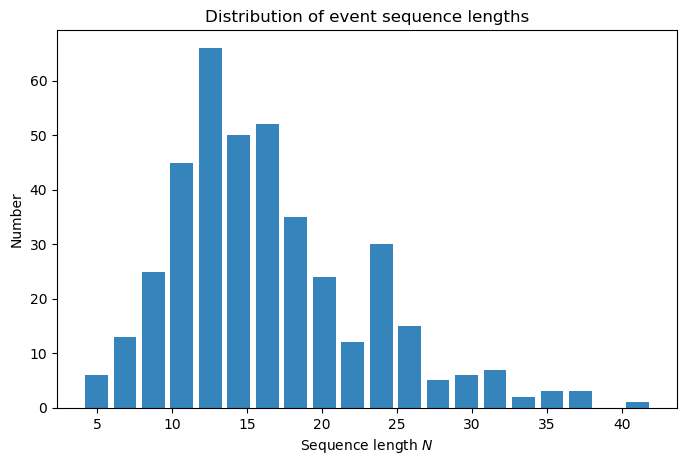

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
ax.hist(seq_lengths, bins=2*int(seq_lengths.size(0)**(2/5)), rwidth=0.8, alpha=0.9)
ax.set_title('Distribution of event sequence lengths')
ax.set_xlabel('Sequence length $N$')
ax.set_ylabel('Number')

In [37]:
data_tensor.shape

torch.Size([400, 42])

The first dimension is for time, the second for the sample.

## Neural net

In [38]:
import torch
import torch.nn as nn
from torch import optim

In [39]:
device = torch.device("cpu")
print(device)

cpu


In [40]:
torch.manual_seed(1)

The intensity process is given by
$$
    \lambda_k(t) = f_k(\mathbf w_\alpha\mathbf h(t) + \mathbf b_\alpha)
$$
with $\mathbf h(t)$ the hidden state, defined from the cell state $\mathbf c(t)$ :
$$
    \mathbf h(t) = \mathbf o_i \odot \tanh(\mathbf c(t))\in\mathbb R^D,\quad t\in(t_{i-1}, t_i].
$$

with
$$
    \mathbf c(t) = \bar{\mathbf c}_{i+1} + (\mathbf c_{i+1} - \bar{\mathbf c}_{i+1})\exp\left(-\delta_{i+1}(t-t_i)\right),\quad t\in(t_{i-1}, t_i].
$$

In [41]:
from models.ctlstm import NeuralCTLSTM
from train_functions import train_neural_ctlstm
import tqdm

In [42]:
# We use mini-batches to train on our data
BATCH_SIZE = 40
print("Batch size: %d" % BATCH_SIZE)
print("Training sample size: %d" % data_tensor.size(0))
print("Splitting into batches of %d" % BATCH_SIZE)
split_into_batches = data_tensor.split(BATCH_SIZE, dim=0)
num_of_batches = len(split_into_batches)
print("No. of batches: %d" % num_of_batches)

hidden_size = 8
learn_rate = 0.0008

nhlstm = NeuralCTLSTM(hidden_size)
optimizer = optim.SGD(nhlstm.parameters(), lr=learn_rate)

Batch size: 40
Training sample size: 400
Splitting into batches of 40
No. of batches: 10


In [43]:
# batch_range = tqdm.trange(num_of_batches)
# batch_range = tqdm.trange(data_tensor.size(0))
train_size = 400
batch_range = tqdm.tqdm_notebook(range(train_size))
loss_hist = []
for i in batch_range:
    batch_range.set_description("Batch %d" % (i+1))
    # sample's event times
    event_times = data_tensor[i]
    loss, hists_ = train_neural_ctlstm(nhlstm, optimizer, event_times, seq_lengths[i], input_size, tmax)
    loss_val = loss.item()
    batch_range.set_postfix(loss=loss_val)
    loss_hist.append(loss_val) # record the loss value

Each training loop:
* reinitializes the hidden states
* zeroes the gradients
* computes the loss

Text(0.5, 0, 'Training samples')

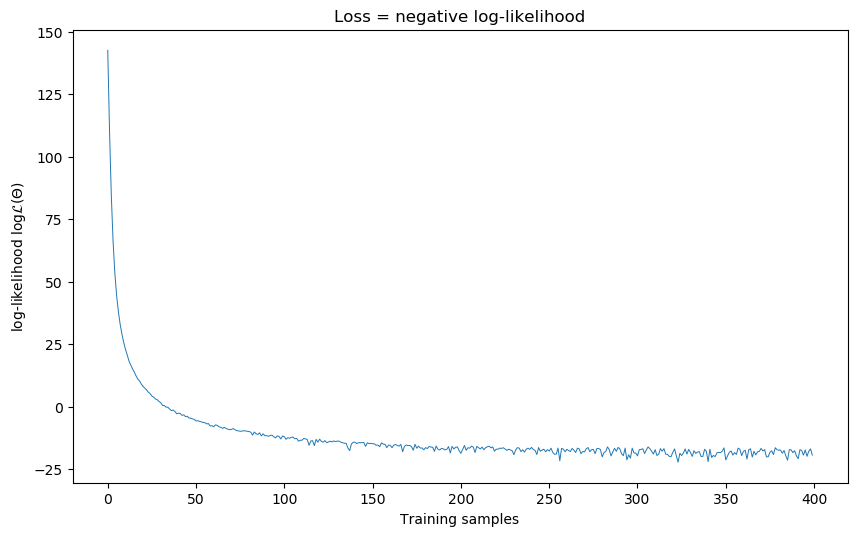

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10,6), dpi=100)

lineopts = {
    "linewidth": 0.7
}
ax.plot(range(train_size), loss_hist, **lineopts)
ax.set_title("Loss = negative log-likelihood")
ax.set_ylabel(r'log-likelihood $\log\mathcal{L}(\Theta)$')
ax.set_xlabel("Training samples")

In [45]:
import datetime

In [46]:
ts = '{:%Y%m%d-%H%M%S}'.format(datetime.datetime.now())

flname = '{:}-{:}.pth'.format(nhlstm.__class__.__name__, ts)
print(flname)
fpath = '../saved_models/{:}'.format(flname)
print(fpath)

torch.save(nhlstm.state_dict(), fpath)

NeuralCTLSTM-20181108-091824.pth
../saved_models/NeuralCTLSTM-20181108-091824.pth


In [47]:
from models.ctlstm import EventGen

In [48]:
nhlstm.eval()
print(nhlstm.training)

False


In [49]:
neural_gen = EventGen(nhlstm)

In [50]:
neural_gen.generate_sequence(tmax)

[0.20062966644763947,
 1.1933772712945938,
 1.7847005873918533,
 2.3531129509210587,
 2.710815981030464,
 3.657070353627205,
 4.030343160033226,
 6.11687408387661,
 6.341632440686226,
 6.425213873386383,
 7.9970592856407166,
 8.4828479886055,
 8.644665852189064,
 9.260286346077919,
 9.831892266869545,
 9.854856656864285]

In [51]:
print(len(neural_gen.sequence_))

16


In [52]:
neural_gen.hidden_hist[-1]

{'hidden': tensor([[ 0.3655, -0.4279,  0.3044, -0.2531,  0.2878, -0.2681,  0.4438, -0.5704]]),
 'cell': tensor([[ 0.8112, -0.8511,  0.7130, -0.5443,  0.8133, -0.5170,  0.7674, -1.0904]]),
 'cell_target': tensor([[ 0.6558, -0.7184,  0.8095, -0.7078,  0.7280, -0.4256,  0.6305, -0.8229]]),
 'cell_decay': tensor([[0.1394]]),
 'output': tensor([[0.5453, 0.6186, 0.4969, 0.5101, 0.4286, 0.5640, 0.6876, 0.7156]])}

In [53]:
from train_functions import make_ctlstm_sequence_plot

In [54]:
time_vals, intens_vals = make_ctlstm_sequence_plot(nhlstm, neural_gen, tmax)

Text(0.5, 1.0, 'Intensity plot for neural Hawkes process')

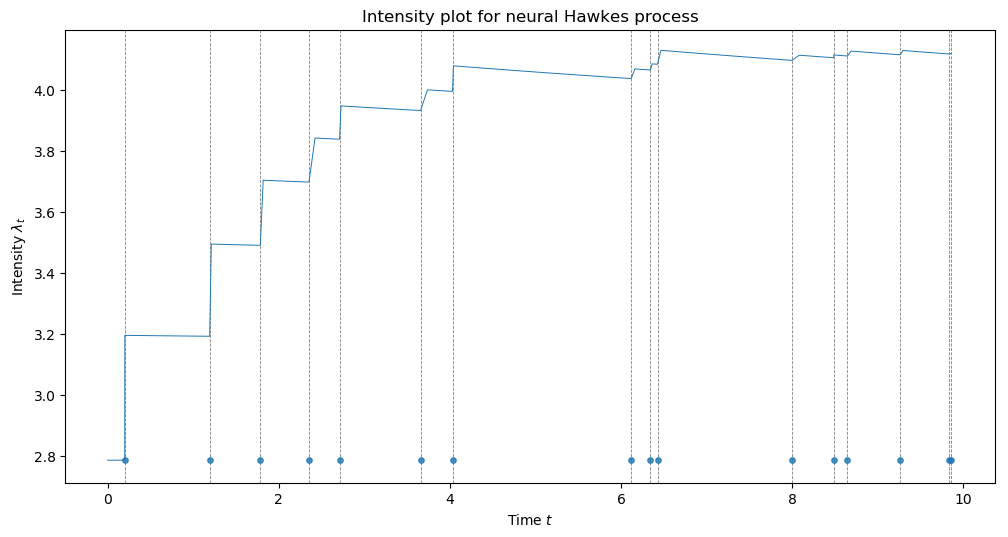

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=100)
ax.plot(time_vals, intens_vals, linewidth=0.7)
for t in neural_gen.sequence_:
    ax.axvline(t, ymin=0.0, ymax=intens_vals.max(), linewidth=0.6,
               linestyle='--',
               alpha=0.5, c='k', zorder=-1)
ax.scatter(neural_gen.sequence_, intens_vals.min() + np.zeros_like(neural_gen.sequence_),
           s=15, alpha=0.8, zorder=1, )
ax.set_xlabel("Time $t$")
ax.set_ylabel("Intensity $\lambda_t$")
ax.set_title("Intensity plot for neural Hawkes process")

In [149]:
x.dot(x)

tensor(4.5233)